In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
import os
import mech_io
from pathlib import Path
%matplotlib inline

In [17]:
db = Path(os.path.abspath('')) / "data" / "database" / "2021-05-31_mech_db_clean.db"
total_gray = '#B7B9C0'
active_green = '#7AAC91'
hype_purp = '#6C3667'
pct_magen = '#A84D6F'

In [3]:
yearly_query = """
    /* keycap group buy yearly aggregate stats */
    SELECT
        ydata.*,
        num_icodes
    FROM (
        SELECT --this derived table calculates most rows
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(tdata.topic_id) as num_gbs,
            COUNT(DISTINCT creator_id) as num_creators,
            CAST(AVG(views) as INT) as avg_views,
            MAX(views) as max_views,
            CAST(AVG(replies) as INT) as avg_replies,
            MAX(replies) as max_replies,
            COUNT(CASE WHEN num_posts >= 25 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_25_posts,
            COUNT(CASE WHEN num_posts >= 50 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_50_posts,
            AVG(IFNULL(ldata.num_links, 0)) as avg_links
        --average time for gbs reaching 25/50 posts
        FROM topic_data as tdata
        LEFT JOIN (
            SELECT
                topic_id,
                COUNT(id) as num_links
            FROM topic_link
            GROUP BY topic_id
            ) ldata
        ON tdata.topic_id = ldata.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) ydata
    JOIN (
        SELECT --this derived table calculates number of infocodes used
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(DISTINCT icode.info_code) as num_icodes
        FROM topic_data as itdata
        JOIN topic_icode as icode
            ON itdata.topic_id = icode.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) iydata
    ON ydata.gb_year = iydata.gb_year
    ORDER BY gb_year;
    """

post50_query = """
    /* keycap group buy time interval stats (aggregate in python)
        - pulls topic level post_50_delta stats
        - sqlite doesn't support time intervals */
    SELECT
        topic_id,
        STRFTIME('%Y', topic_created) as gb_year,
        post_50_delta
    FROM topic_data
    WHERE product_type = 'keycaps'
            AND board_id = '70'
    ORDER BY gb_year, topic_id
    """

# connect to database and pull data
conn = sqlite3.connect(db)
yearly_df = pd.read_sql_query(yearly_query, conn, index_col="gb_year")
post50_df = pd.read_sql_query(post50_query, conn, index_col="topic_id")
conn.close()

In [4]:
# parse post_50_delta to extract day of 50th post (sqlite doesn't support time intervals)
post50_df['post_50_day'] = post50_df['post_50_delta'].apply(lambda x: mech_io.db_parse_td_str(x)['days'])

# filter topics to find hyped topics reaching 50 posts within 30 days
pop_post_df = post50_df[post50_df['post_50_day'] < 30][['gb_year', 'post_50_day']]

# aggregate across years and calculate percent
hype_df = pop_post_df.groupby(['gb_year']).count()
hype_df.rename(columns={'post_50_day':'count_hyped'}, inplace=True)
hype_df['pct_hyped'] = hype_df['count_hyped'] * 100 / yearly_df['num_gbs']

# join aggregated data with other yearly data
yearly_df = yearly_df.join(hype_df)
yearly_df.reset_index(inplace=True)

In [5]:
yearly_df.head(10)

,gb_year,num_gbs,num_creators,avg_views,max_views,avg_replies,max_replies,percent_25_posts,percent_50_posts,avg_links,num_icodes,count_hyped,pct_hyped
0,2012,6,3,28148,123953,146,687,66.666667,50.000000,0.500000,1,3,50.000000
1,2013,19,10,273925,1600608,795,2537,94.736842,89.473684,1.684211,6,16,84.210526
2,2014,11,6,347062,2001068,833,2305,100.000000,90.909091,1.909091,3,10,90.909091
3,2015,16,12,923409,9396954,1320,5922,100.000000,100.000000,2.812500,6,14,87.500000
4,2016,24,20,133977,767197,319,1076,95.833333,83.333333,2.833333,8,16,66.666667
5,2017,38,31,28367,156940,134,885,78.947368,63.157895,3.394737,5,14,36.842105
6,2018,48,39,45693,139646,211,658,97.916667,81.250000,5.354167,8,26,54.166667
7,2019,90,64,62893,199214,154,841,84.444444,70.000000,5.122222,13,36,40.000000
8,2020,148,107,31307,95061,67,243,82.432432,56.756757,9.432432,13,44,29.729730
9,2021,82,76,10996,32540,33,103,64.634146,24.390244,12.987805,11,8,9.756098


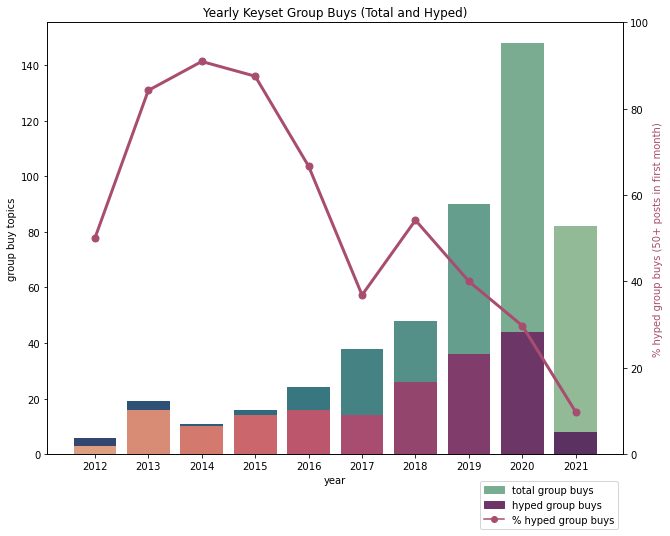

In [6]:
# yearly group buys plot

# create plot and set up twin axis
yearly_plot = plt.figure(figsize=[8,6])
yearly_ax1 = yearly_plot.add_axes([1, 1, 1, 1])
yearly_ax2 = yearly_ax1.twinx()
yearly_ax2.set_ylim(0, 100)

# plot total gbs, "popular" gbs, and % popular gbs
sns.barplot(data=yearly_df, x='gb_year', y='num_gbs', palette='crest_r', ax=yearly_ax1)
sns.barplot(data=yearly_df, x='gb_year', y='count_hyped', palette='flare', ax=yearly_ax1)
yearly_ax2.plot(yearly_df['gb_year'], yearly_df['pct_hyped'], 
                marker='o', linewidth=3, markersize=7, color='#A84D6F')

# make green "active" (same as hyped but with 25 posts)
# <25 is grey

# add axis labels/legend
yearly_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")
yearly_ax1.set_xlabel('year')
yearly_ax1.set_ylabel('group buy topics')
yearly_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color='#A84D6F')
gb_patch = mpatches.Patch(color='#7AAC91', label='total group buys')
pop_patch = mpatches.Patch(color='#6C3667', label='hyped group buys')
pct_patch = mlines.Line2D([], [], color='#A84D6F', marker='o', label='% hyped group buys')
plt.legend(handles=[gb_patch, pop_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')


- since 2014, number of group buys/year has steadily increased
    - however, the number of hyped group buys has steadily been decreasing as a % of total group buys
    - 2021 may be the first year where there is an absolute drop in the number of hyped group buys

- could be an indicator a increasing saturation in the market for group buy keysets
    - production times are increasing and so is the availability of high quality in-stock keycaps
    - if the number of consumers isn't increasing as quickly as the number of group buys, each group buy will receive less attention

- another part of the story - moving from purchasing happening on the forum itself to purchases at spcific regional vendors and proxies 
- the change in hyped group buys partially represents the geekhack threads being used more as an archive or hub vs a place for actual discussion and purchases

In [30]:
discord_query = """
    /* yearly expanded domain/vendor data */
    SELECT
        CASE
            WHEN link LIKE '%discord%' THEN 'discord.gg'
            WHEN LOWER(domain) LIKE ('%' || REPLACE(LOWER(set_name), ' ', '') || '%')
                THEN 'custom domain'
            ELSE LOWER(domain)
        END as domain_type,
        STRFTIME('%Y', tdata.topic_created) as gb_year,
        COUNT(DISTINCT ldata.topic_id) as num_topics,
        COUNT(id) as num_occurances
    FROM topic_link as ldata
    JOIN topic_data as tdata
        ON ldata.topic_id = tdata.topic_id
    WHERE domain_type = 'discord.gg'
    GROUP BY domain_type, gb_year
    ORDER BY gb_year;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
discord_df = pd.read_sql_query(discord_query, conn)
conn.close()

In [31]:
# prep discord data for graphing over full set of years

# join with total number of gbs for each year
discord_years = yearly_df.set_index('gb_year')['num_gbs']
discord_df = discord_df.set_index('gb_year').join(discord_years, how='right')
# discord_df.fillna(value=0, inplace=True)
discord_df.reset_index(inplace=True)

# calculate % of gbs mentioning discord
discord_df['pct_discord'] = discord_df['num_topics'] * 100 / discord_df['num_gbs']



In [32]:
discord_df.tail(5)

,gb_year,domain_type,num_topics,num_occurances,num_gbs,pct_discord
5,2017,NaN,NaN,NaN,38,NaN
6,2018,discord.gg,1.0,1.0,48,2.083333
7,2019,discord.gg,20.0,23.0,90,22.222222
8,2020,discord.gg,63.0,68.0,148,42.567568
9,2021,discord.gg,51.0,72.0,82,62.195122


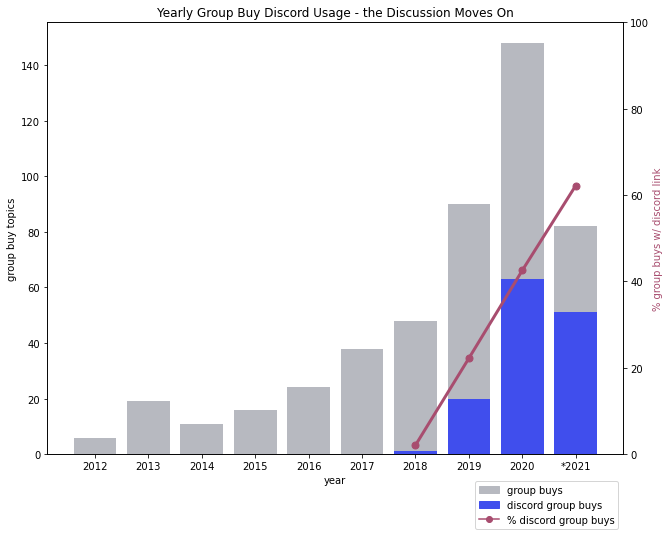

In [34]:
# yearly discord link plot
dcrd_blue = '#404EED'

# create plot and set up twin axis
dcrd_plot = plt.figure(figsize=[8,6])
dcrd_ax1 = dcrd_plot.add_axes([1, 1, 1, 1])
dcrd_ax2 = dcrd_ax1.twinx()

# plot total gbs, "popular" gbs, and % popular gbs
dcrd_xpos = np.arange(len(discord_df['gb_year']))
dcrd_ax1.bar(dcrd_xpos, discord_df['num_gbs'], color=total_gray)
dcrd_ax1.bar(dcrd_xpos, discord_df['num_topics'], color=dcrd_blue)

dcrd_ax2.plot(discord_df['gb_year'], discord_df['pct_discord'], 
                marker='o', linewidth=3, markersize=7, color=pct_magen)

# add axis labels/ticks
dcrd_ax1.set_title("Yearly Group Buy Discord Usage - the Discussion Moves On")

dcrd_ax1.set_xlabel('year')
dcrd_ax1.set_xticks(dcrd_xpos)
dcrd_xpos_lab = discord_df['gb_year'].copy()
dcrd_xpos_lab.iat[-1] = "*" + dcrd_xpos_lab.iat[-1]
dcrd_ax1.set_xticklabels(dcrd_xpos_lab)

dcrd_ax1.set_ylabel('group buy topics')
dcrd_ax2.set_ylabel('% group buys w/ discord link', color=pct_magen)
dcrd_ax2.set_ylim(0, 100)

# create legend
gb_patch = mpatches.Patch(color=total_gray, label='group buys')
dcrd_patch = mpatches.Patch(color=dcrd_blue, label='discord group buys')
pct_patch = mlines.Line2D([], [], color=pct_magen, marker='o', label='% discord group buys')
plt.legend(handles=[gb_patch, dcrd_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')

In [31]:
icode_query = """
/* yearly icode data */
    SELECT
        info_code,
        STRFTIME('%Y', tdata.topic_created) as gb_year,
        COUNT(info_code) as occurances,
        CAST(AVG(tdata.views) as INT) as average_views,
        MAX(tdata.views) as max_views,
        CAST(AVG(tdata.replies) as INT) as average_replies,
        MAX(tdata.replies) as max_replies
    FROM topic_icode as icode
    JOIN topic_data as tdata
        ON icode.topic_id = tdata.topic_id
    WHERE board_id = '70'
    GROUP BY info_code, gb_year
    ORDER BY gb_year;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
icode_df = pd.read_sql_query(y_icode_query, conn)
conn.close()

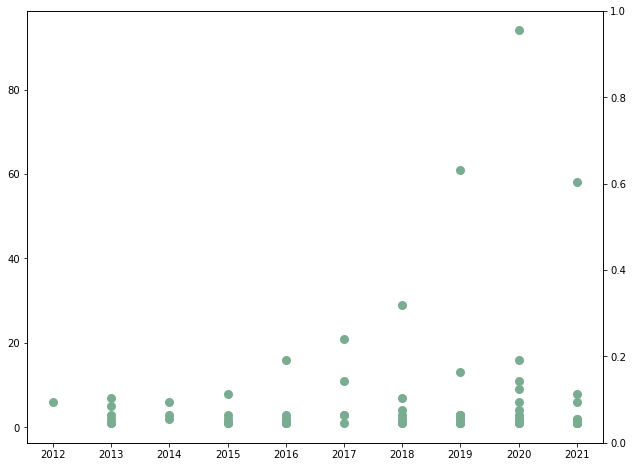

In [34]:
# infocode stats plot

# create plot and set up twin axis
icode_plot = plt.figure(figsize=[8,6])
icode_ax1 = icode_plot.add_axes([1, 1, 1, 1])
icode_ax2 = icode_ax1.twinx()

# plot total gbs, "popular" gbs, and % popular gbs
# sns.barplot(data=yearly_df, x='gb_year', y='num_gbs', palette='crest_r', ax=icode_ax1)
# sns.barplot(data=yearly_df, x='gb_year', y='count_hyped', palette='flare', ax=icode_ax1)
icode_ax1.scatter(icode_df['gb_year'], icode_df['occurances'], 
               marker='o', linewidth=3, color='#7AAC91')
# icode_ax1.scatter(icode_df['occurances'], icode_df['average_views'], 
#                 marker='o', linewidth=3, color='#A84D6F')

# rework this to function on groups of infocodes
# GMK
# Non-GMK ABS
# PBT
# non-standard profiles

# add axis labels/legend
# icode_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")
# icode_ax1.set_xlabel('year')
# icode_ax1.set_ylabel('group buy topics/creators')
# icode_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color='#A84D6F')
# gb_patch = mpatches.Patch(color='#7AAC91', label='group buys')
# pop_patch = mpatches.Patch(color='#6C3667', label='hyped group buys')
# pct_patch = mlines.Line2D([], [], color='#A84D6F', marker='o', label='% hyped group buys')
# plt.legend(handles=[gb_patch, pop_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')

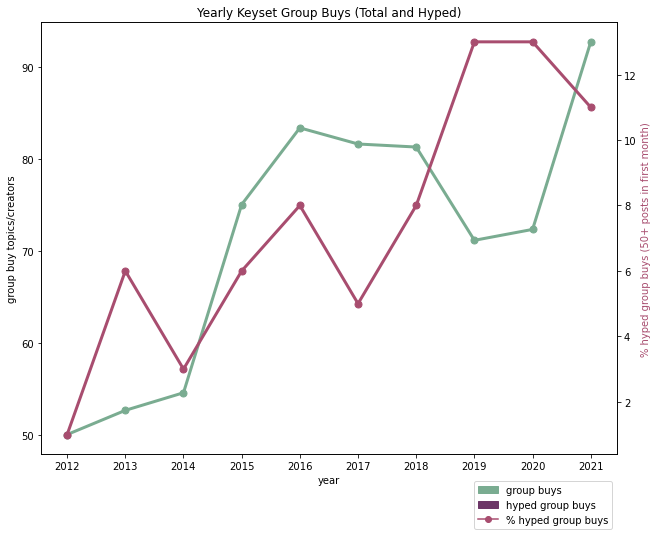

In [23]:
# yearly infocode/creator diversity plot

pct_creators = yearly_df['num_creators'] * 100 / yearly_df['num_gbs']

# create plot and set up twin axis
diver_plot = plt.figure(figsize=[8,6])
diver_ax1 = diver_plot.add_axes([1, 1, 1, 1])
diver_ax2 = diver_ax1.twinx()

# plot total gbs, "popular" gbs, and % popular gbs
# sns.barplot(data=yearly_df, x='gb_year', y='num_gbs', palette='crest_r', ax=diver_ax1)
# sns.barplot(data=yearly_df, x='gb_year', y='count_hyped', palette='flare', ax=diver_ax1)
diver_ax1.plot(yearly_df['gb_year'], pct_creators, 
                marker='o', linewidth=3, markersize=7, color='#7AAC91')
diver_ax2.plot(yearly_df['gb_year'], yearly_df['num_icodes'], 
                marker='o', linewidth=3, markersize=7, color='#A84D6F')


# add axis labels/legend
diver_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")
diver_ax1.set_xlabel('year')
diver_ax1.set_ylabel('group buy topics/creators')
diver_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color='#A84D6F')
gb_patch = mpatches.Patch(color='#7AAC91', label='group buys')
pop_patch = mpatches.Patch(color='#6C3667', label='hyped group buys')
pct_patch = mlines.Line2D([], [], color='#A84D6F', marker='o', label='% hyped group buys')
plt.legend(handles=[gb_patch, pop_patch, pct_patch], bbox_to_anchor=(1, -0.05), loc='upper right')

In [ ]:
# round 2 timing
# graph time since previous round vs previous round replies? views?
# 